We now compute the largest Lyapunov exponent according to the algorithm of XXX. Again, define the Loren model

In [4]:
using ODE
using Pkg
using LinearAlgebra
using Plots

The Lorenz model can be simply defined and, as we see it, Julia accepts greek symbols. We provide a function of the parameters, which returns the Lorenz model. 

In [5]:
function lorenz_model(σ,ρ,β)
    function lorenz(t,u)
        dxdt = σ*(u[2]-u[1])
        dydt = u[1]*(ρ-u[3]) - u[2]
        dzdt = u[1]*u[2] - β*u[3]
        [dxdt;dydt;dzdt]
    end
    return(lorenz)
end

lorenz_model (generic function with 1 method)

We produce a time series, as in Appendix B. 

In [7]:
dt = 0.01
tf = 2000.0
t  = collect(0:dt:tf)
u0=[0.1;0.1;0.1]
σ=10
β=8/3.
ρ=28.
(t, u) = ode45(lorenz_model(σ,ρ,β), u0, t);

We now consider the dynamics of a first-order perturbation $\delta u$ evaluated in $u$:

In [10]:
function lorenz_linear_tangent(σ,ρ,β)
    function linear_tangent(δu,u)
        dδxdt =  -σ*δu[1] + σ*δu[2]
        dδydt =  (ρ-u[3])*δu[1] - δu[2] - u[1]*δu[3]
        dδzdt =  u[2]*δu[1] + u[1]*δu[2] - β*δu[3]
        return([dδxdt; dδydt ; dδzdt ])
    end
    return(linear_tangent)
end

lorenz_linear_tangent (generic function with 1 method)

We consider an arbitrary initial perturbation $\delta u$ of norm $||\delta u||=1$, and code it as a column vector

In [11]:
deltau=[0;1.;0.]

3-element Vector{Float64}:
 0.0
 1.0
 0.0

In [28]:
function iterate_lyapunov(linear_tangent, deltau, u, spinup, iren)
    
    lambda=1. ; time = 0;
    lambdas=[];
    times=[];
    δu = deltau;
    i=0; j=0;
    for u_ in u;
        # the second order scheme appears here crucial to have good-enough results
        predictor = δu + linear_tangent(δu,u_)*dt
        δu += 0.5*(linear_tangent(δu,u_) +  linear_tangent(predictor,u_)) *dt 
        i+=1;
        j+=1;
        if (i==iren);
            ndu = norm(δu)
            δu=δu/ndu
            i=0;
            if(j > spinup);
                time += dt*iren
                lambda+=log(ndu)
                append!(lambdas,lambda)
                append!(times, time)
            end;
        end;
    end
    return(times, lambdas)
end

iterate_lyapunov (generic function with 1 method)

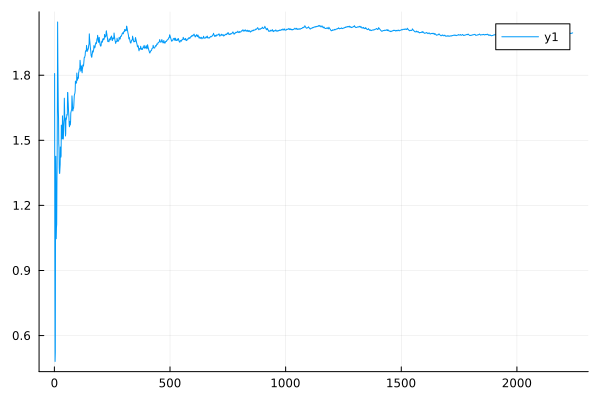

In [29]:
(times,lambdas)=iterate_lyapunov(lorenz_linear_tangent(σ,ρ,β), 
    deltau, u,70000,90);
plot( lambdas ./ times)

In [30]:
print(last(lambdas)/last(times))

1.9950050654839755

We now wrap up these operations in a function to see the evolution of the largest Lyapunov exponent with $ρ$

In [31]:
function largestlyap(ρ)
    u0=[0.;0.1;0.1]
    (dummyt,u) = ode45(lorenz_model(σ,ρ,β), u0, t);
    δu=[0;0;1.]
    (times,lambdas)=iterate_lyapunov(lorenz_linear_tangent(σ,ρ,β), δu, u,120000,90)
    last(lambdas)/last(times)
end
    

largestlyap (generic function with 1 method)

In [36]:
largestlyap(23)

-0.052571553134038725

In [38]:
rhos=collect(1:.4:40)
lambdas = map(largestlyap,rhos);

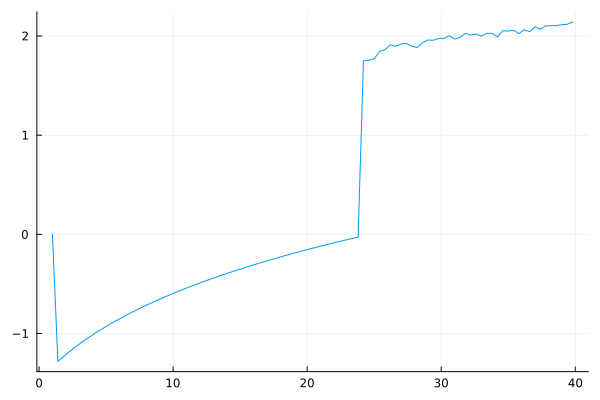

In [44]:
plot(rhos,lambdas, legend=false)

As we see it, the chaotic behaviour emerges for the $r_H$ value that we have predicted analytically. 

In [41]:
rhos[first(findall(lambdas .> 0))]

24.2